In [1]:
%matplotlib inline
'''
How to Optimize Your Dragon: V1
Import initialized model and start the optimization
'''
# system imports
import sys
import os
import datetime
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../..'))

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

import dill

# pyomo imports
from pyomo import environ as pe
from global_sets.component import m

from stages.reactive_stage import reactive_stage_rule
from stages.condenser_stage import condenser_stage_rule
from stages.reboiler_stage import reboiler_stage_rule

from utility.display_utility import beautify, beautify_reactive, HiddenLogs, HiddenPrints, plot_distribution,\
                                    trans_cnumber, trans_product_mole
from utility.model_utility import add_dual, update_dual, delete_dual, check_DOF# , check_violate_constraint
from utility.data_utility import cal_cnumber
from utility.time_utility import create_filename_time, log_now, log_end

2018-07-09 21:43:31 - Start Program


In [2]:
product = {}
product['napha'] = [i for i in m.COMP_ORG if cal_cnumber(i) >= 5 and cal_cnumber(i) <= 7]
product['gasoline'] = [i for i in m.COMP_ORG if cal_cnumber(i) >= 8 and cal_cnumber(i) <= 12]
product['diesel'] = [i for i in m.COMP_ORG if cal_cnumber(i) >= 13 and cal_cnumber(i) <= 18]
product['heavy'] = [i for i in m.COMP_ORG if cal_cnumber(i) >= 19 and cal_cnumber(i) <= 56]

In [3]:
logname = create_filename_time()
log_text_dir = './log/text/opt_'+logname+'.dat'
log_figure_dir = './log/figure/opt_'+logname+'.pdf'

In [4]:
def see_product(model):
    cd_x_data = []; rf_x_data = {}; rb_x_data = []

    cd_x_data = trans_product_mole({i:model.condenser.x[i].value for i in m.COMP_TOTAL})
    for j in model.reactive:
        rf_x_data[j] = trans_product_mole({i:model.reactive[j].x[i].value for i in m.COMP_TOTAL})
    rb_x_data = trans_product_mole({i:model.reboiler.x[i].value for i in m.COMP_TOTAL})

    print('Napha:\t\t{:.2f}'.format(cd_x_data['scaled']['napha']))
    print('Gasoline:\t{:.2f}'.format(rf_x_data[7]['scaled']['gasoline']))
    print('Diesel:\t\t{:.2f}'.format(rf_x_data[10]['scaled']['diesel']))
    print('Heavy:\t\t{:.2f}'.format(rb_x_data['scaled']['heavy']))

In [5]:
with open('./log/model/stage_20_base.pickle','rb') as f:
    model = dill.load(f)

In [6]:
for j in model.reactive:
    model.reactive[j].MPCC.pf.fix(0)
model.reboiler.MPCC.pf.fix(0)

In [7]:
opt = pe.SolverFactory('ipopt')

opt.options['print_user_options'] = 'yes'
opt.options['linear_solver'] = 'ma86'

opt.options['linear_system_scaling '] = 'mc19'
opt.options['linear_scaling_on_demand '] = 'no'

opt.options['max_iter'] = 7000
opt.options['warm_start_init_point'] = 'yes'
opt.options['warm_start_bound_push'] = 1e-20
opt.options['warm_start_mult_bound_push'] = 1e-20
opt.options['mu_init'] = 1e-6

In [8]:
results = opt.solve(model,tee=True)
update_dual(pe,model)

Ipopt 3.12.8: print_user_options=yes
linear_solver=ma86
linear_system_scaling =mc19
linear_scaling_on_demand =no
max_iter=7000
warm_start_init_point=yes
warm_start_bound_push=1e-20
warm_start_mult_bound_push=1e-20
mu_init=1e-06


List of user-set options:

                                    Name   Value                used
                linear_scaling_on_demand = no                    yes
                           linear_solver = ma86                  yes
                   linear_system_scaling = mc19                  yes
                                max_iter = 7000                  yes
                                 mu_init = 1e-06                 yes
                      print_user_options = yes                   yes
                   warm_start_bound_push = 1e-20                 yes
                   warm_start_init_point = yes                   yes
              warm_start_mult_bound_push = 1e-20                 yes

****************************************************

In [9]:
pdf = PdfPages(log_figure_dir)


> Original 20 stage case
------------------------------------------------------------------------------------------------------------
Here comes the result:
------------------------------------------------------------------------------------------------------------
stages			T	Q				V_out	L_out	L_Prod		W
Condenser		30.00	-134.				3.0267	0.6407	0.0337		2.0654

stages			T	Q	r_FT	Conversion	V_out	L_out	L_Prod		P_VLE
NON-react[1]		119.3	0.000	0.0000	0.000		5.7667	0.7437	0.0000		20.000
NON-react[2]		131.1	0.000	0.0000	0.000		5.8697	0.6752	0.0000		20.000
NON-react[3]		140.3	0.000	0.0000	0.000		5.8012	0.6136	0.0000		20.000
NON-react[4]		148.7	0.000	0.0000	0.000		5.7396	0.5249	0.0218		20.000
NON-react[5]		157.3	0.000	0.0000	0.000		5.6727	0.4430	0.0000		20.000
NON-react[6]		167.3	0.000	0.0000	0.000		5.5909	0.3311	0.0000		20.000
NON-react[7]		181.1	0.000	0.0000	0.000		5.4790	0.1558	0.0389		20.000
React-ive[8]		200.0	-24.4	0.1555	0.201		5.3427	0.0671	0.0000		20.000
React-ive[9]		210.0	-33.7	0.1961

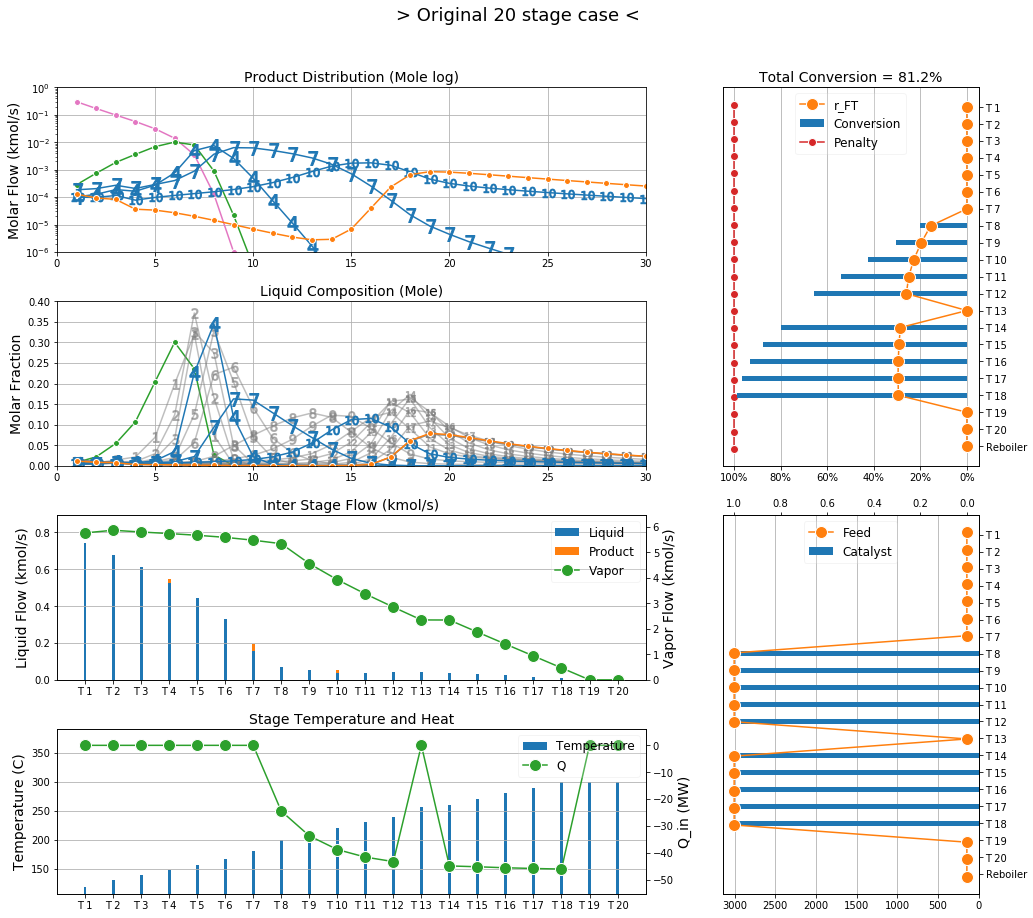

In [10]:
with HiddenLogs(log_text_dir,'w'):
    print('\n>','Original 20 stage case')
    print('-'*108)
    beautify(pe,model)
    see_product(model)
    log_now()

plot_distribution(model,pdf,'Original 20 stage case')

# Optimization Input

**Parameters:**
* Stage Temperature
    * Rectifying section: 200C - 300C
    * Stripping section: 200C - 300C
* Reflux
    * Distillate / (Distillate + Reflux): 0.5 - 0.05, Refulx Ratio: 1 - 19


**Constraints:**
* Product
    * Distillate: C5~C7 >= 0.75
    * Gasoline: C8~C12 >= 0.75
    * Diesel: C13~C18 >= 0.6
    * Heavy: C19+ >= 0.85
    
**Objective:**
* Max gasoline production

### Parameters

In [11]:
for j in range(8,13):
    model.reactive[j].T.setlb(200+273.15)
    model.reactive[j].T.setub(300+273.15)
for j in range(14,19):
    model.reactive[j].T.setlb(200+273.15)
    model.reactive[j].T.setub(300+273.15)
    
model.condenser.PR_L.unfix()
model.condenser.PR_L.setlb(0.05)
model.condenser.PR_L.setub(0.5)

### Constraints

In [12]:
model.quality_coefficient = pe.Param(within=pe.NonNegativeReals,mutable=True,initialize=1)

In [13]:
model.product_spec_con = pe.ConstraintList()

In [14]:
model.product_spec_con.add(expr = sum(model.condenser.x[i] for i in product['napha']) >= \
                           model.quality_coefficient*0.75*sum(model.condenser.x[i] for i in m.COMP_ORG));
model.product_spec_con.add(expr = sum(model.reactive[7].x[i] for i in product['gasoline']) >= \
                           model.quality_coefficient*0.75*sum(model.reactive[7].x[i] for i in m.COMP_ORG));
model.product_spec_con.add(expr = sum(model.reactive[10].x[i] for i in product['diesel']) >= \
                           model.quality_coefficient*0.6*sum(model.reactive[10].x[i] for i in m.COMP_ORG));
model.product_spec_con.add(expr = sum(model.reboiler.x[i] for i in product['heavy']) >= \
                           model.quality_coefficient*0.85*sum(model.reboiler.x[i] for i in m.COMP_ORG));

### Objective

In [15]:
model.del_component(model.obj)

In [16]:
model.obj = pe.Objective(expr = model.reactive[7].L['P'] - sum(model.reactive[j].MPCC.pf for j in model.reactive)\
                                - model.reboiler.MPCC.pf, sense = pe.maximize)

In [17]:
# increase the penalty weight
# for j in model.reactive:
#     model.reactive[j].MPCC.rho = 100
# model.reboiler.MPCC.rho = 100

In [18]:
results = opt.solve(model,tee=True)
update_dual(pe,model)

Ipopt 3.12.8: print_user_options=yes
linear_solver=ma86
linear_system_scaling =mc19
linear_scaling_on_demand =no
max_iter=7000
warm_start_init_point=yes
warm_start_bound_push=1e-20
warm_start_mult_bound_push=1e-20
mu_init=1e-06


List of user-set options:

                                    Name   Value                used
                linear_scaling_on_demand = no                    yes
                           linear_solver = ma86                  yes
                   linear_system_scaling = mc19                  yes
                                max_iter = 7000                  yes
                                 mu_init = 1e-06                 yes
                      print_user_options = yes                   yes
                   warm_start_bound_push = 1e-20                 yes
                   warm_start_init_point = yes                   yes
              warm_start_mult_bound_push = 1e-20                 yes

****************************************************

  67 -6.3503596e-02 3.68e+01 1.45e+02  -6.0 7.09e+03    -  2.65e-01 1.65e-01w  1
  68 -6.0430894e-02 3.12e+01 1.22e+02  -6.0 4.56e+03 -10.0 5.76e-02 1.54e-01w  1
  69 -6.9777137e-02 1.54e+01 2.04e+02  -6.0 1.02e+04  -9.6 1.71e-01 1.21e-02h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 -6.9360424e-02 1.52e+01 1.59e+02  -6.0 6.27e+03    -  2.32e-01 1.48e-02h  3
  71 -6.8692316e-02 1.49e+01 1.51e+02  -6.0 5.02e+03    -  8.38e-02 2.80e-02h  3
  72 -6.8364127e-02 1.48e+01 1.29e+02  -6.0 5.97e+03    -  3.00e-01 1.43e-02h  4
  73 -6.7915280e-02 1.46e+01 1.25e+02  -6.0 4.27e+03    -  4.66e-02 3.10e-02h  4
  74 -6.7607959e-02 1.44e+01 1.16e+02  -6.0 5.00e+03    -  2.34e-01 2.42e-02h  4
  75 -6.7470640e-02 1.43e+01 1.21e+02  -6.0 5.34e+03    -  2.33e-01 1.36e-02h  5
  76 -6.6937530e-02 1.40e+01 1.15e+02  -6.0 3.55e+03    -  3.81e-02 4.09e-02h  4
  77 -6.7266392e-02 1.50e+01 1.15e+02  -6.0 2.98e+04    -  2.96e-02 9.30e-03h  4
  78 -6.7468152e-02 1.51e+01


> Optimized Temperature and Reflux
------------------------------------------------------------------------------------------------------------
Here comes the result:
------------------------------------------------------------------------------------------------------------
stages			T	Q				V_out	L_out	L_Prod		W
Condenser		30.00	-150.				2.4093	0.8985	0.0472		2.2855

stages			T	Q	r_FT	Conversion	V_out	L_out	L_Prod		P_VLE
NON-react[1]		118.0	0.000	0.0000	0.000		5.6407	1.0720	0.0000		20.000
NON-react[2]		126.7	0.000	0.0000	0.000		5.8141	0.9939	0.0000		20.000
NON-react[3]		134.8	0.000	0.0000	0.000		5.7361	0.9317	0.0000		20.000
NON-react[4]		143.2	0.000	0.0000	0.000		5.6739	0.8302	0.0345		20.000
NON-react[5]		152.2	0.000	0.0000	0.000		5.6070	0.7389	0.0000		20.000
NON-react[6]		163.0	0.000	0.0000	0.000		5.5157	0.5993	0.0000		20.000
NON-react[7]		178.4	0.000	0.0000	0.000		5.3761	0.3337	0.0834		20.000
React-ive[8]		200.0	-30.5	0.1303	0.210		5.1939	0.2946	0.0000		20.000
React-ive[9]		237.4	-3

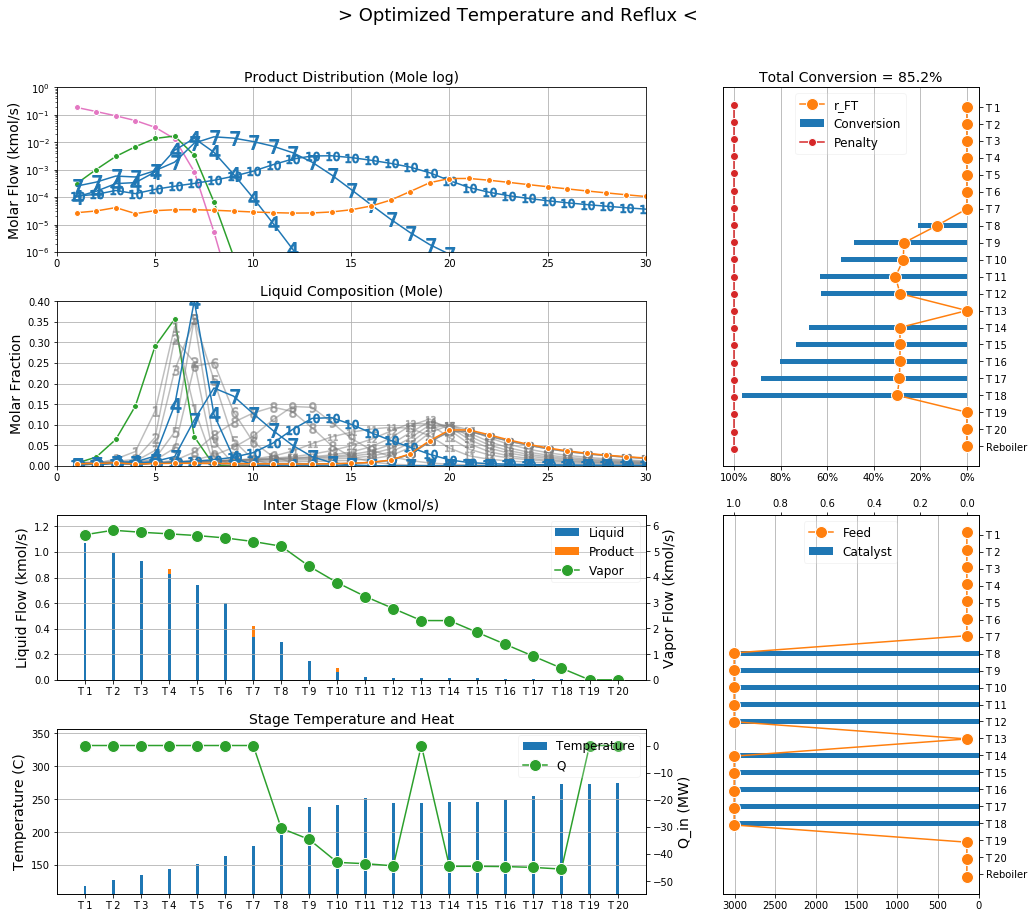

In [19]:
with HiddenLogs(log_text_dir):
    print('\n>','Optimized Temperature and Reflux')
    print('-'*108)
    beautify(pe,model)
    see_product(model)
    log_now()

plot_distribution(model,pdf,'Optimized Temperature and Reflux')

# Open up side-draw

**Parameters:**
* Stage Temperature
    * Rectifying section: 200C - 300C
    * Stripping section: 200C - 300C
* Reflux
    * Distillate / (Distillate + Reflux): 0.5 - 0.05, Refulx Ratio: 1 - 19
* Side-draw ratio
    * PR_L: 0 - 1

**Constraints:**
* Product
    * Distillate: C5~C7 >= 0.75
    * Gasoline: C8~C12 >= 0.75
    * Diesel: C13~C18 >= 0.6
    * Heavy: C19+ >= 0.85
    
**Objective:**
* Max gasoline production

In [20]:
model.reactive[7].PR_L.unfix()
model.reactive[10].PR_L.unfix()

In [21]:
results = opt.solve(model,tee=True)
update_dual(pe,model)

Ipopt 3.12.8: print_user_options=yes
linear_solver=ma86
linear_system_scaling =mc19
linear_scaling_on_demand =no
max_iter=7000
warm_start_init_point=yes
warm_start_bound_push=1e-20
warm_start_mult_bound_push=1e-20
mu_init=1e-06


List of user-set options:

                                    Name   Value                used
                linear_scaling_on_demand = no                    yes
                           linear_solver = ma86                  yes
                   linear_system_scaling = mc19                  yes
                                max_iter = 7000                  yes
                                 mu_init = 1e-06                 yes
                      print_user_options = yes                   yes
                   warm_start_bound_push = 1e-20                 yes
                   warm_start_init_point = yes                   yes
              warm_start_mult_bound_push = 1e-20                 yes

****************************************************


> Optimized Product Side Draw
------------------------------------------------------------------------------------------------------------
Here comes the result:
------------------------------------------------------------------------------------------------------------
stages			T	Q				V_out	L_out	L_Prod		W
Condenser		30.00	-147.				2.3257	0.7582	0.0619		2.3096

stages			T	Q	r_FT	Conversion	V_out	L_out	L_Prod		P_VLE
NON-react[1]		118.9	0.000	0.0000	0.000		5.4555	0.8926	0.0000		20.000
NON-react[2]		127.8	0.000	0.0000	0.000		5.5899	0.8249	0.0000		20.000
NON-react[3]		135.6	0.000	0.0000	0.000		5.5222	0.7737	0.0000		20.000
NON-react[4]		143.2	0.000	0.0000	0.000		5.4710	0.6877	0.0286		20.000
NON-react[5]		151.2	0.000	0.0000	0.000		5.4137	0.6063	0.0000		20.000
NON-react[6]		161.2	0.000	0.0000	0.000		5.3322	0.4745	0.0000		20.000
NON-react[7]		176.7	0.000	0.0000	0.000		5.2005	0.2016	0.0936		20.000
React-ive[8]		200.0	-34.5	0.1297	0.214		5.0212	0.2205	0.0000		20.000
React-ive[9]		245.5	-37.1	0

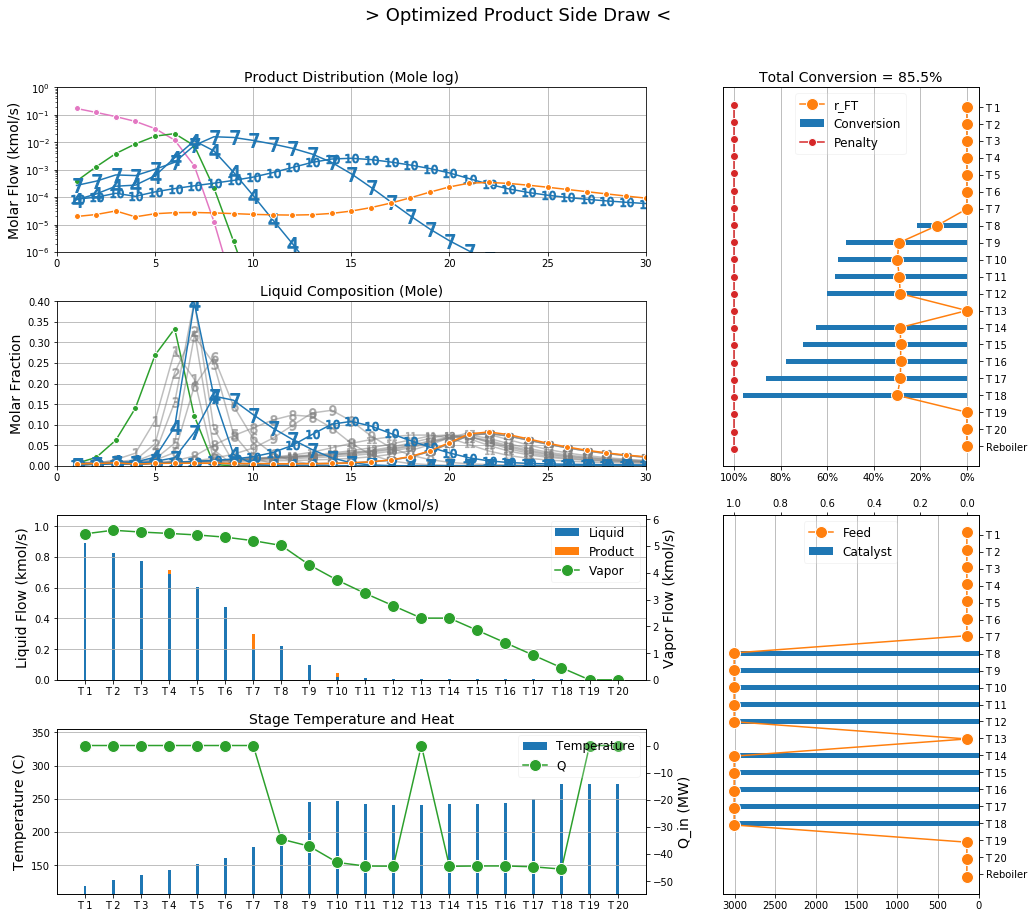

In [22]:
with HiddenLogs(log_text_dir):
    print('\n>','Optimized Product Side Draw')
    print('-'*108)
    beautify(pe,model)
    see_product(model)
    log_now()

plot_distribution(model,pdf,'Optimized Product Side Draw')

# Open up feed allocation

**Parameters:**
* Stage Temperature
    * Rectifying section: 200C - 300C
    * Stripping section: 200C - 300C
* Reflux
    * Distillate / (Distillate + Reflux): 0.5 - 0.05, Refulx Ratio: 1 - 19
* Side-draw
    * PR_L: 0 - 1
    
* Feed
    * F: 0 - 3

**Constraints:**
* Product
    * Distillate: C5~C7 >= 0.75
    * Gasoline: C8~C12 >= 0.75
    * Diesel: C13~C18 >= 0.6
    * Heavy: C19+ >= 0.85
    
* Total feed
    * Total feed = 10 kmol/s
    
**Objective:**
* Max gasoline production

In [23]:
for j in model.reactive:
    model.reactive[j].F.unfix()
    model.reactive[j].F.setlb(0)
    model.reactive[j].F.setub(3)

In [24]:
model.total_feed_con = pe.ConstraintList()

In [25]:
model.total_feed_con.add(expr = sum(model.reactive[j].F for j in model.reactive) == 10);

In [26]:
results = opt.solve(model,tee=True)
update_dual(pe,model)

Ipopt 3.12.8: print_user_options=yes
linear_solver=ma86
linear_system_scaling =mc19
linear_scaling_on_demand =no
max_iter=7000
warm_start_init_point=yes
warm_start_bound_push=1e-20
warm_start_mult_bound_push=1e-20
mu_init=1e-06


List of user-set options:

                                    Name   Value                used
                linear_scaling_on_demand = no                    yes
                           linear_solver = ma86                  yes
                   linear_system_scaling = mc19                  yes
                                max_iter = 7000                  yes
                                 mu_init = 1e-06                 yes
                      print_user_options = yes                   yes
                   warm_start_bound_push = 1e-20                 yes
                   warm_start_init_point = yes                   yes
              warm_start_mult_bound_push = 1e-20                 yes

****************************************************

  68 -1.1310747e-01 7.02e+01 2.47e+02  -9.0 2.88e+03    -  4.49e-04 2.00e-02h  1
  69 -1.1310874e-01 6.94e+01 2.46e+02  -9.0 2.17e+03    -  6.73e-03 1.15e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 -1.1311367e-01 6.63e+01 2.52e+02  -9.0 2.10e+03    -  1.22e-02 4.66e-02h  1
  71 -1.1311993e-01 6.22e+01 2.26e+02  -9.0 2.09e+03    -  8.94e-02 6.62e-02h  1
  72 -1.1315774e-01 4.79e+01 4.85e+02  -9.0 2.09e+03    -  4.01e-02 4.54e-01h  1
  73 -1.1317971e-01 3.89e+01 3.67e+02  -9.0 2.00e+03    -  1.06e-01 3.83e-01h  1
  74 -1.1322586e-01 5.07e+01 1.54e+02  -9.0 1.92e+03    -  5.85e-01 8.67e-01h  1
  75 -1.1325663e-01 4.01e+01 4.24e+01  -9.0 1.73e+03    -  5.07e-01 6.25e-01h  1
  76 -1.1326361e-01 3.53e+01 2.37e+01  -9.0 1.76e+03    -  2.20e-01 1.48e-01h  1
  77 -1.1326702e-01 3.30e+01 4.63e+02  -9.0 1.80e+03    -  2.90e-02 7.26e-02h  1
  78 -1.1326493e-01 2.35e+01 3.12e+02  -9.0 2.61e+02    -  3.67e-02 2.90e-01h  1
  79 -1.1326285e-01 1.81e+01


> Optimized Feed Amount and Location
------------------------------------------------------------------------------------------------------------
Here comes the result:
------------------------------------------------------------------------------------------------------------
stages			T	Q				V_out	L_out	L_Prod		W
Condenser		30.00	-147.				1.9364	0.6945	0.0760		2.3783

stages			T	Q	r_FT	Conversion	V_out	L_out	L_Prod		P_VLE
NON-react[1]		120.9	0.000	0.0000	0.000		5.0853	0.8113	0.0000		20.000
NON-react[2]		129.2	0.000	0.0000	0.000		5.2021	0.7488	0.0000		20.000
NON-react[3]		136.8	0.000	0.0000	0.000		5.1396	0.7031	0.0000		20.000
NON-react[4]		144.1	0.000	0.0000	0.000		5.0939	0.6252	0.0260		20.000
NON-react[5]		152.0	0.000	0.0000	0.000		5.0421	0.5510	0.0000		20.000
NON-react[6]		161.9	0.000	0.0000	0.000		4.9678	0.4299	0.0000		20.000
NON-react[7]		177.3	0.000	0.0000	0.000		4.8467	0.1548	0.1132		20.000
React-ive[8]		200.0	-20.1	0.0404	0.100		4.6849	0.2114	0.0000		20.000
React-ive[9]		240.8	

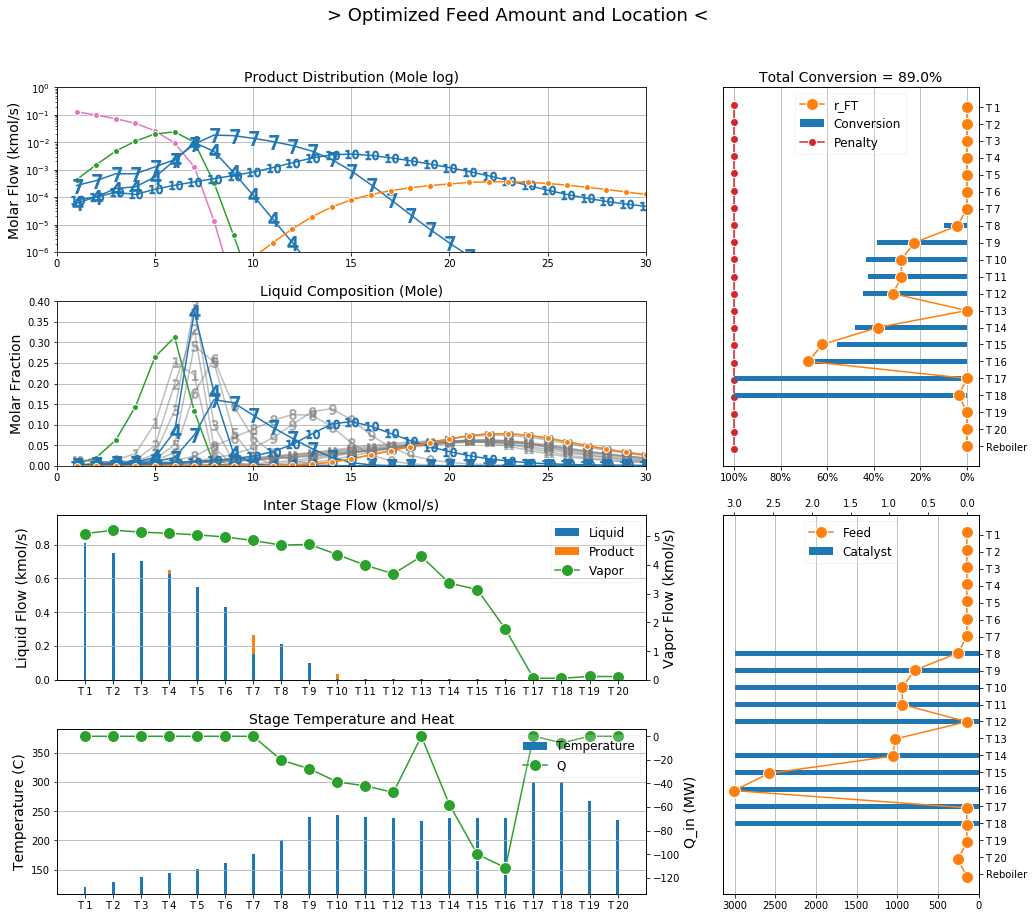

In [27]:
with HiddenLogs(log_text_dir):
    print('\n>','Optimized Feed Amount and Location')
    print('-'*108)
    beautify(pe,model)
    see_product(model)
    log_now()

plot_distribution(model,pdf,'Optimized Feed Amount and Location')

# Increase spec a little bit

**Parameters:**
* Stage Temperature
    * Rectifying section: 200C - 300C
    * Stripping section: 200C - 300C
* Reflux
    * Distillate / (Distillate + Reflux): 0.5 - 0.05, Refulx Ratio: 1 - 19
* Side-draw
    * PR_L: 0 - 1
    
* Feed
    * F: 0 - 3

**Constraints:**
* Product
    * Distillate: C5~C7 >= 0.75
    * Gasoline: C8~C12 >= **0.8**
    * Diesel: C13~C18 >= 0.6
    * Heavy: C19+ >= 0.85
    
* Total feed
    * Total feed = 10 kmol/s
    
**Objective:**
* Max gasoline production

In [28]:
model.product_spec_con.add(expr = sum(model.reactive[7].x[i] for i in product['gasoline']) >= \
                           model.quality_coefficient*0.8*sum(model.reactive[7].x[i] for i in m.COMP_ORG));

In [29]:
results = opt.solve(model,tee=True)
update_dual(pe,model)

In [30]:
with HiddenLogs(log_text_dir):
    print('\n>','Increase Gasoline Specification to 80%')
    print('-'*108)
    beautify(pe,model)
    see_product(model)
    log_now()

plot_distribution(model,pdf,'Increase Gasoline Specification to 80%')

# Open up catalyst allocation ( = TOTAL reconstruction, long wait time)

**Parameters:**
* Stage Temperature
    * Rectifying section: 200C - 300C
    * Stripping section: 200C - 300C
* Reflux
    * Distillate / (Distillate + Reflux): 0.5 - 0.05, Refulx Ratio: 1 - 19
* Side-draw
    * PR_L: 0 - 1
    
* Feed
    * F: 0 - 3
        
* Catalyst
    * cat: 0 - 10000

**Constraints:**
* Product
    * Distillate: C5~C7 >= 0.75
    * Gasoline: C8~C12 >= 0.75 / 0.8
    * Diesel: C13~C18 >= 0.6
    * Heavy: C19+ >= 0.85
    
* Total feed
    * sum feed = 10 kmol/s
    
* Total catalyst
    * sum cat = 30000 kg
    
**Objective:**
* Max gasoline production

In [31]:
for j in model.reactive:
    model.reactive[j].cat.unfix()
    model.reactive[j].cat.setlb(0)
    model.reactive[j].cat.setub(10000)

In [32]:
model.total_cat_con = pe.ConstraintList()

In [33]:
model.total_cat_con.add(expr = sum(model.reactive[j].cat for j in model.reactive) == 10*3000);

In [34]:
results = opt.solve(model,tee=True)
update_dual(pe,model)

Ipopt 3.12.8: print_user_options=yes
linear_solver=ma86
linear_system_scaling =mc19
linear_scaling_on_demand =no
max_iter=7000
warm_start_init_point=yes
warm_start_bound_push=1e-20
warm_start_mult_bound_push=1e-20
mu_init=1e-06


List of user-set options:

                                    Name   Value                used
                linear_scaling_on_demand = no                    yes
                           linear_solver = ma86                  yes
                   linear_system_scaling = mc19                  yes
                                max_iter = 7000                  yes
                                 mu_init = 1e-06                 yes
                      print_user_options = yes                   yes
                   warm_start_bound_push = 1e-20                 yes
                   warm_start_init_point = yes                   yes
              warm_start_mult_bound_push = 1e-20                 yes

****************************************************

  75 -8.3463009e-02 1.42e+01 5.97e+00  -6.0 4.38e+01    -  1.92e-02 2.10e-02h  1
  76 -8.6449371e-02 1.02e+01 3.15e+02  -6.0 2.15e+01    -  1.06e-01 2.81e-01h  1
  77 -8.6733619e-02 9.86e+00 3.05e+02  -6.0 1.71e+01    -  3.31e-01 3.49e-02h  1
  78 -8.7723103e-02 8.62e+00 3.48e+02  -6.0 1.69e+01    -  2.95e-01 1.25e-01h  1
  79 -8.8547823e-02 7.65e+00 1.04e+03  -6.0 2.23e+01    -  4.31e-01 1.13e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80 -8.8732629e-02 7.49e+00 1.07e+03  -6.0 3.66e+02    -  3.09e-02 2.09e-02h  1
  81 -8.9351083e-02 7.08e+00 1.30e+03  -6.0 4.28e+02    -  1.25e-01 5.57e-02h  1
  82 -8.9366354e-02 7.01e+00 5.02e+03  -6.0 8.64e+01  -2.0 5.11e-04 9.80e-03h  1
  83 -9.0796396e-02 5.48e+00 7.88e+03  -6.0 1.21e+02  -2.5 4.06e-02 2.19e-01h  1
  84 -9.0796687e-02 5.48e+00 7.84e+03  -6.0 1.26e+01  -1.2 5.45e-02 6.10e-05h  1
  85 -9.0947445e-02 5.30e+00 7.65e+03  -6.0 6.01e+01  -1.6 7.04e-03 3.30e-02h  1
  86 -9.0987426e-02 5.24e+00

 168 -9.2274919e-02 1.23e+00 1.70e+05  -6.0 1.70e+01  -0.4 3.58e-02 8.07e-02h  1
 169 -9.2285094e-02 1.23e+00 1.70e+05  -6.0 2.00e+01  -0.9 4.80e-03 2.80e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170 -9.2294483e-02 1.22e+00 1.69e+05  -6.0 1.56e+01  -0.5 6.30e-03 2.96e-03h  1
 171 -9.2477958e-02 1.16e+00 1.56e+05  -6.0 2.24e+01  -1.0 8.75e-03 4.88e-02h  1
 172 -9.2533804e-02 1.14e+00 1.52e+05  -6.0 1.49e+01  -0.5 1.72e-02 1.96e-02h  1
 173 -9.2536407e-02 1.14e+00 1.52e+05  -6.0 2.34e+01  -1.0 2.31e-02 8.28e-04h  1
 174 -9.2538925e-02 1.14e+00 1.52e+05  -6.0 1.41e+01  -0.6 2.44e-02 9.08e-04h  1
 175 -9.2601808e-02 1.12e+00 1.49e+05  -6.0 2.83e+01  -1.1 2.06e-02 1.85e-02h  1
 176 -9.2663653e-02 1.09e+00 1.44e+05  -6.0 1.45e+01  -0.6 1.06e-01 2.39e-02h  1
 177 -9.2711550e-02 1.08e+00 1.42e+05  -6.0 3.61e+01  -1.1 1.64e-01 1.46e-02h  1
 178 -9.2896684e-02 9.91e-01 1.22e+05  -6.0 1.40e+01  -0.7 3.00e-02 7.88e-02h  1
 179r-9.2896684e-02 9.91e-01

 261 -8.6503982e-02 1.88e+02 2.75e+02  -6.0 2.43e+03    -  1.64e-02 1.55e-02h  1
 262 -8.6406463e-02 1.88e+02 2.71e+02  -6.0 2.63e+03    -  3.17e-02 4.03e-03h  3
 263 -8.6413867e-02 1.88e+02 6.95e+04  -6.0 3.75e+01   5.5 8.54e-05 8.48e-05h  1
 264r-8.6413867e-02 1.88e+02 9.99e+02   0.3 0.00e+00   5.0 0.00e+00 2.84e-07R  4
 265r-8.6346959e-02 1.79e+02 8.43e+04   0.3 5.69e+03    -  5.40e-03 7.39e-05f  1
 266r-8.7290196e-02 3.43e+01 8.07e+04   0.3 9.76e+02    -  4.25e-02 5.55e-03f  1
 267 -8.7287488e-02 3.43e+01 3.81e+02  -6.0 2.89e+03    -  8.08e-04 3.15e-04h  1
 268 -8.7168284e-02 3.42e+01 3.72e+02  -6.0 2.84e+03    -  4.42e-02 3.02e-03h  3
 269 -8.7011320e-02 3.41e+01 3.68e+02  -6.0 2.65e+03    -  1.86e-02 4.88e-03h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 270 -8.6861614e-02 3.39e+01 3.55e+02  -6.0 2.66e+03    -  7.82e-02 5.32e-03h  3
 271 -8.6761910e-02 3.37e+01 3.50e+02  -6.0 2.75e+03    -  3.19e-02 3.89e-03h  5
 272 -8.6645674e-02 3.36e+01

 347 -9.8160785e-02 2.18e+01 1.04e+03  -6.0 5.41e+01  -0.7 1.98e-04 3.52e-05h  1
 348 -9.8158951e-02 2.18e+01 9.12e+02  -6.0 7.50e+01  -1.2 8.51e-04 9.60e-05h  1
 349 -9.8127376e-02 2.18e+01 1.21e+03  -6.0 8.07e+01  -1.7 1.87e-04 2.24e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 350 -9.8114665e-02 2.17e+01 7.86e+02  -6.0 8.15e+01  -2.1 5.93e-03 2.15e-03h  1
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
 351 -9.8145554e-02 2.16e+01 9.06e+02  -6.0 8.80e+01  -2.6 1.47e-03 4.75e-03h  2
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
 352 -9.8180898e-02 2.15e+01 5.88e+02  -6.0 8.38e+01  -3.1 1.68e-02 3.63e-03h  2
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
 353 -9.8270045e-02 2.14e+01 5.86e+02  -6.0 1.06e+02  -3.6 1.96e-02 6.25e-03h  2
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
 354 -9.8300998e-02 2.13e+01 5.84e+0

 419 -7.3852666e-02 1.87e+01 9.00e+04  -6.0 1.19e+03    -  1.02e-01 1.73e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 420 -7.3402306e-02 1.83e+01 8.88e+04  -6.0 3.91e+03    -  4.46e-02 2.69e-02h  1
 421 -7.3398215e-02 1.83e+01 8.89e+04  -6.0 5.70e+02  -0.4 4.22e-05 3.63e-04h  1
 422 -7.3397821e-02 1.83e+01 8.89e+04  -6.0 6.32e+02  -0.9 1.03e-04 2.91e-05h  1
 423 -7.3372580e-02 1.82e+01 8.91e+04  -6.0 7.80e+02  -1.4 2.43e-03 1.29e-03h  1
 424 -7.3215266e-02 1.81e+01 9.21e+04  -6.0 7.90e+02  -1.8 1.40e-03 8.10e-03h  1
 425 -7.2769079e-02 1.77e+01 1.00e+05  -6.0 8.14e+02  -2.3 4.46e-02 2.30e-02h  1
 426 -7.1607754e-02 1.70e+01 1.22e+05  -6.0 8.60e+02  -2.8 4.84e-02 5.97e-02h  1
 427 -7.1211014e-02 1.67e+01 1.21e+05  -6.0 8.92e+02  -3.3 2.08e-02 2.10e-02h  1
 428 -6.9850780e-02 1.63e+01 1.24e+05  -6.0 9.63e+02  -3.7 2.55e-07 7.01e-02h  1
 429 -6.7884090e-02 1.55e+01 1.26e+05  -6.0 8.83e+02  -4.2 4.21e-02 1.21e-01h  1
iter    objective    inf_pr 

 511 -9.1154056e-02 1.03e+01 1.81e+03  -6.0 1.93e+03    -  5.61e-02 3.72e-01h  1
 512 -9.1628490e-02 3.53e+00 2.11e+03  -6.0 1.15e+01  -5.8 1.74e-01 6.58e-01h  1
 513 -9.2676333e-02 8.06e-01 2.68e+02  -6.0 1.79e+01  -6.2 6.74e-01 1.00e+00h  1
 514 -9.3008196e-02 9.31e-02 3.02e+01  -6.0 6.10e+00  -5.8 9.88e-01 1.00e+00h  1
 515 -9.3723073e-02 1.61e-01 1.58e+02  -6.0 1.49e+01  -6.3 9.54e-01 1.00e+00h  1
 516 -9.4175288e-02 2.46e-01 1.42e+02  -6.0 2.36e+01  -6.8 5.26e-01 4.53e-01h  1
 517 -9.5550007e-02 9.88e-01 2.61e+01  -6.0 4.83e+01  -7.2 1.00e+00 9.25e-01h  1
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
 518 -9.5880735e-02 8.76e-01 3.38e+01  -6.0 1.31e+02  -7.7 5.26e-01 1.27e-01h  2
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
 519 -9.7153210e-02 6.33e-01 4.42e+01  -6.0 2.41e+02  -8.2 6.13e-01 2.62e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 520 -1.0030042e-01 1.42e+00 2.6

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600 -1.1780229e-01 6.67e-02 3.80e+02  -6.0 1.43e+01  -8.1 1.00e+00 7.35e-01h  1
 601 -1.1779728e-01 6.64e-03 1.61e+02  -6.0 1.16e+01  -8.6 5.38e-01 1.00e+00h  1
 602 -1.1779179e-01 4.59e-02 8.25e-02  -6.0 3.26e+01  -9.0 1.00e+00 1.00e+00h  1
 603 -1.1779269e-01 1.96e-01 4.99e-02  -6.0 1.01e+02  -9.5 1.00e+00 1.00e+00h  1
 604 -1.1779320e-01 3.78e-01 2.54e+01  -6.0 1.26e+03 -10.0 1.00e+00 3.75e-02h  2
 605 -1.1779883e-01 5.68e+00 6.42e+00  -6.0 8.46e+02 -10.5 1.00e+00 7.44e-01h  1
 606 -1.1780461e-01 7.29e+00 6.98e+01  -6.0 2.50e+03 -10.9 1.00e+00 1.73e-01h  1
 607 -1.1780346e-01 3.61e+01 2.49e+02  -6.0 1.58e+04 -11.4 3.32e-01 9.28e-02h  1
 608 -1.1779926e-01 3.68e+01 1.04e+03  -6.0 7.19e+03    -  2.14e-01 7.02e-02h  1
 609 -1.1779817e-01 3.61e+01 1.04e+03  -6.0 4.66e+03    -  3.44e-01 1.12e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 610 -1.1779083e-01 5.06e+01

 692 -1.2096361e-01 2.07e-03 4.98e+02  -9.0 2.03e+00  -6.7 6.12e-01 6.23e-01f  1
 693 -1.2097033e-01 2.89e-03 3.03e+02  -9.0 6.07e+00  -7.2 1.56e-02 3.91e-01f  1
 694 -1.2097108e-01 2.77e-03 2.87e+02  -9.0 3.94e+00  -6.8 7.85e-01 5.25e-02f  1
 695 -1.2097122e-01 2.73e-03 2.82e+02  -9.0 3.41e+00  -6.4 2.16e-01 1.62e-02f  1
 696 -1.2098162e-01 6.37e-03 7.92e+01  -9.0 3.90e+00  -6.9 1.00e+00 7.20e-01f  1
 697 -1.2098526e-01 6.34e-03 7.20e+01  -9.0 1.17e+01  -7.3 5.09e-01 9.02e-02h  1
 698 -1.2098679e-01 1.90e-03 2.27e+01  -9.0 8.67e-01  -6.0 9.71e-01 6.85e-01f  1
 699 -1.2098801e-01 1.64e-03 1.89e+01  -9.0 2.43e+00  -6.5 1.00e+00 1.67e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700 -1.2099466e-01 2.67e-03 1.24e+01  -9.0 6.39e+00  -7.0 4.56e-01 3.43e-01f  1
 701 -1.2101783e-01 1.79e-02 6.09e+00  -9.0 1.43e+01  -7.4 7.18e-02 5.10e-01f  1
 702 -1.2102163e-01 1.20e-02 3.21e-01  -9.0 8.30e-01  -6.1 6.53e-01 1.00e+00h  1
 703 -1.2103808e-01 8.19e-02

In iteration 783, 1 Slack too small, adjusting variable bound
 784 -1.2268475e-01 5.32e-02 6.32e-01  -9.0 2.05e-01  -4.2 3.23e-01 5.76e-01h  1
 785 -1.2268472e-01 2.71e-02 4.05e-01  -9.0 8.60e-02  -4.7 7.54e-01 4.89e-01h  1
 786 -1.2268479e-01 1.64e-05 2.24e-01  -9.0 9.15e-02  -5.2 2.45e-01 1.00e+00h  1
 787 -1.2268479e-01 1.58e-05 2.30e-01  -9.0 6.20e-02  -5.6 9.32e-01 3.81e-02h  1
 788 -1.2268488e-01 2.23e-05 3.01e-04  -9.0 1.65e-01  -6.1 1.00e+00 1.00e+00f  1
 789 -1.2268514e-01 1.80e-04 7.79e-05  -9.0 4.94e-01  -6.6 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 790 -1.2268590e-01 1.70e-03 6.51e-04  -9.0 1.48e+00  -7.1 1.00e+00 1.00e+00h  1
 791 -1.2268811e-01 1.39e-02 5.14e-03  -9.0 4.43e+00  -7.5 1.00e+00 1.00e+00h  1
 792 -1.2269236e-01 5.30e-02 2.29e-02  -9.0 1.32e+01  -8.0 1.00e+00 7.18e-01h  1
 793 -1.2270656e-01 6.49e-01 1.56e-01  -9.0 3.90e+01  -8.5 1.00e+00 1.00e+00f  1
 794 -1.2270811e-01 9.56e-01 2.65e-01  -9.0 2.5


> Optimized Catalyst Amount and Location
------------------------------------------------------------------------------------------------------------
Here comes the result:
------------------------------------------------------------------------------------------------------------
stages			T	Q				V_out	L_out	L_Prod		W
Condenser		30.00	-150.				1.7259	0.6621	0.0777		2.4676

stages			T	Q	r_FT	Conversion	V_out	L_out	L_Prod		P_VLE
React-ive[1]		121.7	0.000	0.0000	0.000		4.9334	0.7745	0.0000		20.000
React-ive[2]		129.4	0.000	0.0000	0.000		5.0459	0.7144	0.0000		20.000
React-ive[3]		136.6	0.000	0.0000	0.000		4.9857	0.6711	0.0000		20.000
React-ive[4]		143.9	0.000	0.0000	0.000		4.9424	0.5971	0.0248		20.000
React-ive[5]		151.7	0.000	0.0000	0.000		4.8933	0.5259	0.0000		20.000
React-ive[6]		161.7	0.000	0.0000	0.000		4.8221	0.4091	0.0000		20.000
React-ive[7]		177.3	0.000	0.0000	0.000		4.7053	0.1322	0.1230		20.000
React-ive[8]		200.0	-12.9	0.0000	0.000		4.5515	0.1917	0.0000		20.000
React-ive[9]		23

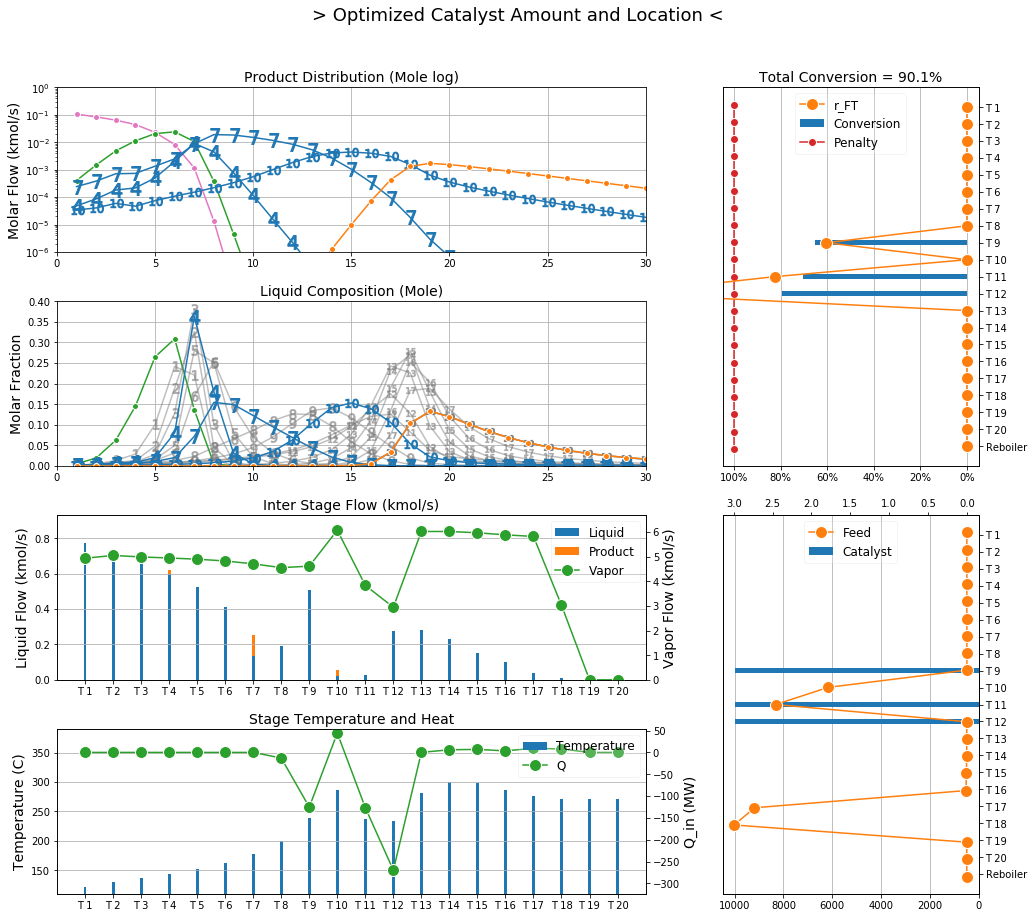

In [35]:
with HiddenLogs(log_text_dir):
    print('\n>','Optimized Catalyst Amount and Location')
    print('-'*108)
    beautify(pe,model)
    see_product(model)
    log_now()

plot_distribution(model,pdf,'Optimized Catalyst Amount and Location')

In [36]:
pdf.close()